# PXD011691 Data

## Published data from 2019

### Data reanalysis performed by Phil Wilmarth, PSR Core OHSU

### This notebook uses the edgeR exact test

### Compare random 5x5 samples from BGS site

#### February 23, 2023

---

- [Overview](#overview)
- [Read in the data](#load_data) 
- [Clustering and normalization](#TMM)
- [SET1 versus SET2](#DE) 
- [Summary](#summary)

---

## <a name="overview"></a>Overview

Data from the 10-fraction TMT part of [PXD011691](http://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD011691) described in (**Muntel 2019**) [the paywalled paper is here](https://pubs.acs.org/doi/abs/10.1021/acs.jproteome.8b00898). The paper nominally compares single-shot DIA analyses (library and library-free with [Spectronaut](https://biognosys.com/software/spectronaut/)) to fractionated TMT-labeled analyses. The number of fractions for the TMT experiment was designed to use a similar total LC-MS time as the single-shot method. The samples were predominantly digests of 10 purchased mouse brain samples. 

All the wet bench work was done at one lab. The final mass spec samples for the low-pH reverse phase chromatography runs were split and two laboratories generated data from the same instrument models. The two lab datasets are, in essence, LC-MS technical replicates. One possible data comparison is between the two labs by either DIA or TMT methods.

Each lab did the DIA and TMT experiments. Another comparison would be between DIA and TMT from each lab site. The samples are the same and the study designs, while different, are how studies with each method would typically be done. The "proteome" comparison is challenging for several reasons. We need to define what we mean by proteomes. We need to create and describe procedures for comparing proteomes. We do not know how similar or different single shot versus fractionated proteomes are if we used only one quantitative proteomics technique. We do not know if proteomes from DIA are similar to DDA proteomes. We do not know how stable isotope labeled proteomes compare to label-free proteomes. We do not know how different data analysis pipelines affect proteomes. This is a difficult problem.

The publication also spiked-in human UPS2 protein digests to the mouse background. Much of the paper focuses on concepts of accuracy and precision using the UPS2 proteins. However, the spike-in design is poor (a common theme among spike-in experimental designs), and the data is not worth the time to analyze. Major flaws in the spike-in experiment are high homology between human and mouse house-keeping proteins (the UPS proteins are mostly common house-keeping proteins), picking UPS2 instead of UPS1 (UPS2 has proteins in groups of 8 that have 5 decades of concentration difference), doing 5 dilutions of a spike-in sample that already has dilutions (kind of a dilution squared situation) for 10 samples (comparisons are n=2 cases), and very low levels of UPS2 proteins that compromise detectability (only 12-19 of the 48 proteins could be detected). The UPS2 spike-in is an unnecessary distraction.

### This notebook

This notebook looks at whether we can control false positive differential abundance (DE) candidates coming from the mouse background proteins. We could drop the UPS2 proteins, but, since we are working with the IRS data here where the S5 samples are taken off the table, we will leave them in. We have 10 mouse samples from the combined data. We will do a 5 versus 5 testing with 5 samples drawn randomly from the 10 samples to make two groups. 

### Sample Key:

This is a guessed sample key based on the total intensity of UPS2 proteins to the total intensity of mouse proteins for each TMT channel (after excluding decoys and contaminants).

TMT10 Label Reagent|Sample_ID in each plex
:---:|:---
126C|S4-1 
127N|S2-1  
127C|S5-1 (IRS)  
128N|S4-2 
128C|S3-1  
129N|S2-2  
129C|S3-2
130N|S1-1 
130C|S5-2 (IRS)
131N|S1-2

--- 

Data were reprocessed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (**Wilmarth 2009**) using a current canonical mouse sequence collection (from UniProt with 21K sequences). There were several issues with the Proteome Discoverer v2.2 TMT data presented in the paper. The FASTA file for mouse was the somewhat incomplete UniProt Swiss-Prot (less than 17K sequences from 2016), Mascot was used for PSM identification of the low-res ion trap data in the SPS-MS3 method with so-so parameters, signal-to-noise ratios were used for reporter ions (measurements have units, folks), the protein inference method in PD was not described, and the sample key (what TMT tags were used for the samples) was not specified (neither in the paper nor the repository).

### References

> Muntel, J., Kirkpatrick, J., Bruderer, R., Huang, T., Vitek, O., Ori, A. and Reiter, L., 2019. Comparison of protein quantification in a complex background by DIA and TMT workflows with fixed instrument time. Journal of proteome research, 18(3), pp 1340-1351.

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

---

## Load the necessary R libraries

In [1]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




## Define common functions for notebook use

In [2]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE, table = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    if(table == TRUE) {
        cat("\nLibrary size factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    }
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    if(table == TRUE) {
        cat("\nTrimmed mean of M-values (TMM) factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    }
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    if(table == TRUE) {
        cat("\nCombined (lib size and TMM) normalization factors:\n", 
            sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))
    }

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============ runs an edgeR exact pairwise test ========================
pairwise_test <- function(delist, pair, p.value) {
    # runs an edgeR exact test and returns results
    et <- exactTest(delist, pair = pair)
    tt <- topTags(et, n = Inf, sort.by = "none")
    
    # print top tags
    cat("\n")
    print(topTags(et)$table, digits = 4)
    cat("\n")
    
    # count candidates
    print(summary(decideTestsDGE(et, p.value = p.value)))

    # see candidates on an MA plot
    plotMD(et, p.value = p.value)
    abline(h = c(-1, 1), col = "black")
    
    # check the p-value distribution
    pval <- ggplot(tt$table, aes(PValue)) + 
      geom_histogram(bins = 100, fill = "white", color = "black") + 
      geom_hline(yintercept = mean(hist(et$table$PValue, breaks = 100, 
                                    plot = FALSE)$counts[26:100])) +
      ggtitle("p-value distribution")
    print(pval) # this makes the plot show up
    
    tt # return top-tags object
}

# ================= reformat edgeR test results ================================
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags table from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate <- cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                     labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

# =============== log2_fold_changes ================================================
log2_fold_changes <- function(results, left, right, title) {
    # Makes log2 fold change plots by candidate
        # results - results data frame
        # left - lower FC log2 limit
        # right - upper FC log2 limit
        # title - plot title
    
    # see how many candidates by category
    cat("\n")
    print(results %>% count(candidate))
    cat("\n")

    # plot log2 fold-changes by category
    fc <- ggplot(results, aes(x = logFC, fill = candidate)) +
      geom_histogram(binwidth=0.1, color = "black") +
      facet_wrap(~candidate) +
      coord_cartesian(xlim = c(-left, right)) +
      ggtitle(title)
    print(fc)
}

# ========== Setup for MA and volcano plots ====================================
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

# ========== MA plots using ggplot =============================================
MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

# ========== Scatter plots using ggplot ========================================
scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

# ========== Volcano plots using ggplot ========================================
volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

# ============== individual protein expression plots ===========================
# function to extract the identifier part of the accesssion
get_identifier <- function(accession) {
    identifier <- str_split(accession, "\\|", simplify = TRUE)
    identifier[,3]
#    identifier <- accession
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

plot_top_tags <- function(results, nleft, nright, top_tags, color = c("red", "blue")) {
    # results should have data first, then test results (two condition summary table)
    # nleft, nright are number of data points in each condition
    # top_tags is number of up and number of down top DE candidates to plot
    # get top ipregulated
    up <- results %>% 
        filter(logFC >= 0) %>%
        arrange(FDR)
    up <- up[1:top_tags, ]
    
    # get top down regulated
    down <- results %>% 
        filter(logFC < 0) %>%
        arrange(FDR)
    down <- down[1:top_tags, ]
    
    # pack them
    proteins <- rbind(up, down)
        
    color_bars = c(rep(color[1], nleft), rep(color[2], nright))
    for (row_num in 1:nrow(proteins)) {
        row <- proteins[row_num, ]
        vec <- as.vector(unlist(row[1:(nleft + nright)]))
        names(vec) <- colnames(row[1:(nleft + nright)])
        title <- str_c(get_identifier(row$Acc), ", int: ", scientific(mean(vec), 2), 
                       ", FDR: ", scientific(row$FDR, digits = 3), 
                       ", FC: ", round(row$FC, digits = 1),
                       ", ", row$candidate)
        barplot(vec, col = color_bars, main = title,
                cex.main = 1.0, cex.names = 0.7, cex.lab = 0.7)
    }    
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

## <a name="load_data"></a>Read the IRS-normalized TMT intensity data

We checked the data quality in an earlier notebook, and it looked okay.

In [3]:
# load the IRS-normalized data and check the table
data_import <- read_tsv("BGS-quant-table.txt")

# save gene names for edgeR so we can double check that results line up
accessions <- data_import$Accession

# see how many rows of data we have
length(accessions)

# set some larger plot dimensions
set_plot_dimensions(9, 9)

Parsed with column specification:
cols(
  Accession = col_character(),
  `S4-1` = col_double(),
  `S2-1` = col_double(),
  `S5-1` = col_double(),
  `S4-2` = col_double(),
  `S3-1` = col_double(),
  `S2-2` = col_double(),
  `S3-2` = col_double(),
  `S1-1` = col_double(),
  `S5-2` = col_double(),
  `S1-2` = col_double()
)



[1] 6539

### Organize the data frame by biological group

In [4]:
# put together in one frame
tmt_irs <- data_import[-1]

# split the data into two random groups (5x5)
indices <- 1:10
set1 <- sample(indices, 5)
set2 <- indices[-set1]
tmt_irs <- cbind(tmt_irs[set1], tmt_irs[set2])

cat(colnames(tmt_irs), sep = "\n")

S1-2
S4-1
S5-2
S1-1
S2-1
S5-1
S4-2
S3-1
S2-2
S3-2


In [5]:
# define which columns go with each group
SET1 <- 1:5
SET2 <- 6:10

# set some colors by group
colors_group = c(rep('red', 5), rep('blue', 5))

## <a name="TMM"></a>Load data into edgeR data structures

We are defining the groups that will be compared explicitly and using all the samples for variance estimates. We put the data into a data frame, grouped by condition. We defined some column indexes for each condition, set some colors for plotting. We can run TMM normalization, check the final intensity distributions, and see how distinct the biological groups are in an MDS cluster view.


Library size factors:
 S1-2  -> 1.024613
 S4-1  -> 1.059976
 S5-2  -> 0.979937
 S1-1  -> 0.969273
 S2-1  -> 1.150269
 S5-1  -> 0.979796
 S4-2  -> 0.917406
 S3-1  -> 0.977217
 S2-2  -> 1.023185
 S3-2  -> 0.954413

Trimmed mean of M-values (TMM) factors:
 S1-2  -> 0.979663
 S4-1  -> 1.022149
 S5-2  -> 1.003409
 S1-1  -> 1.008995
 S2-1  -> 1.001914
 S5-1  -> 1.001408
 S4-2  -> 0.986795
 S3-1  -> 0.983059
 S2-2  -> 0.991442
 S3-2  -> 1.022179

Combined (lib size and TMM) normalization factors:
 S1-2  -> 1.003776
 S4-1  -> 1.083454
 S5-2  -> 0.983278
 S1-1  -> 0.977991
 S2-1  -> 1.152471
 S5-1  -> 0.981176
 S4-2  -> 0.905292
 S3-1  -> 0.960662
 S2-2  -> 1.014429
 S3-2  -> 0.975581


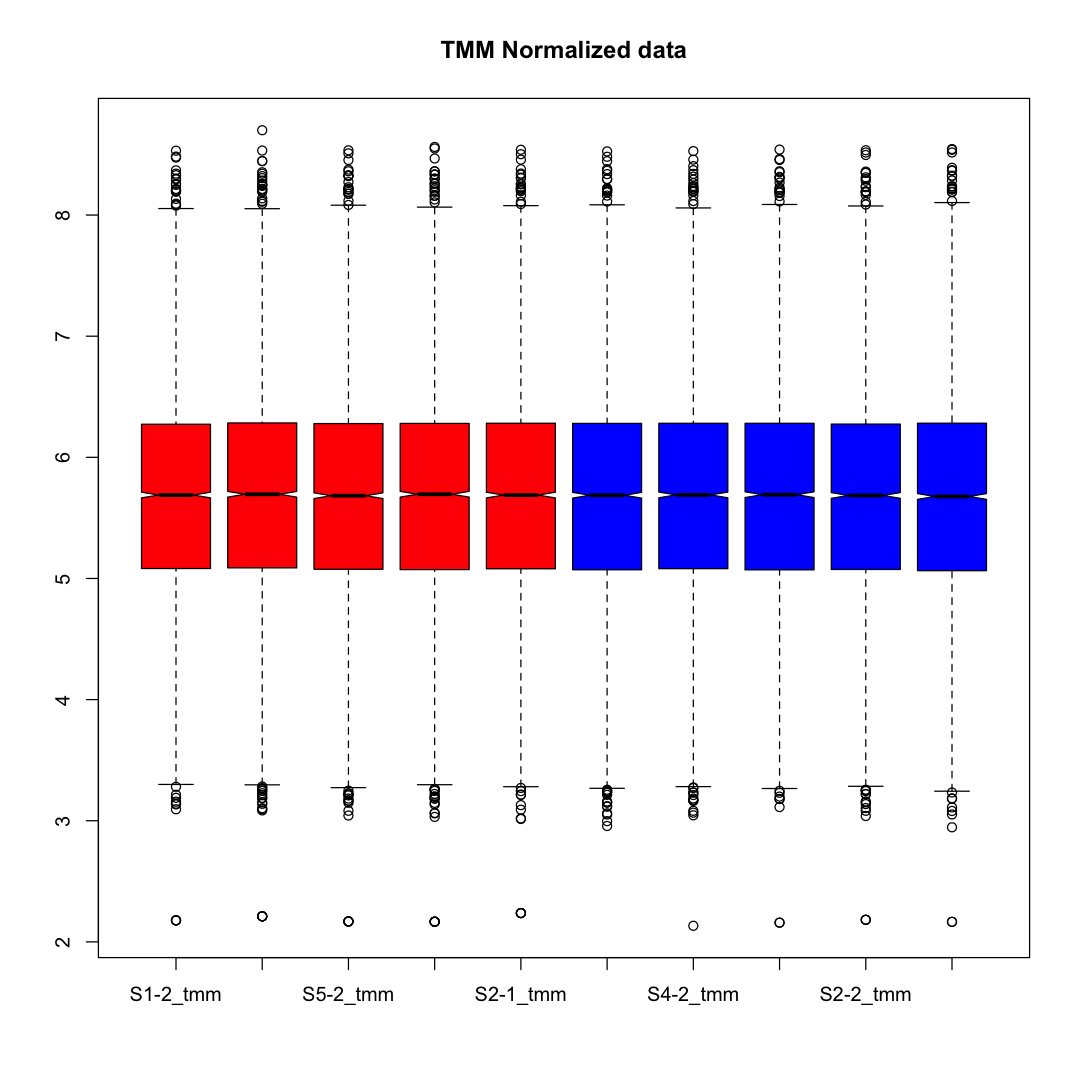

In [6]:
# get the biological sample data into a DGEList object
group = c(rep("SET1", length(SET1)), rep("SET2", length(SET2)))
y <- DGEList(counts = tmt_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the TMM-normalized intensities
tmt_tmm <- apply_tmm_factors(y, color = colors_group)

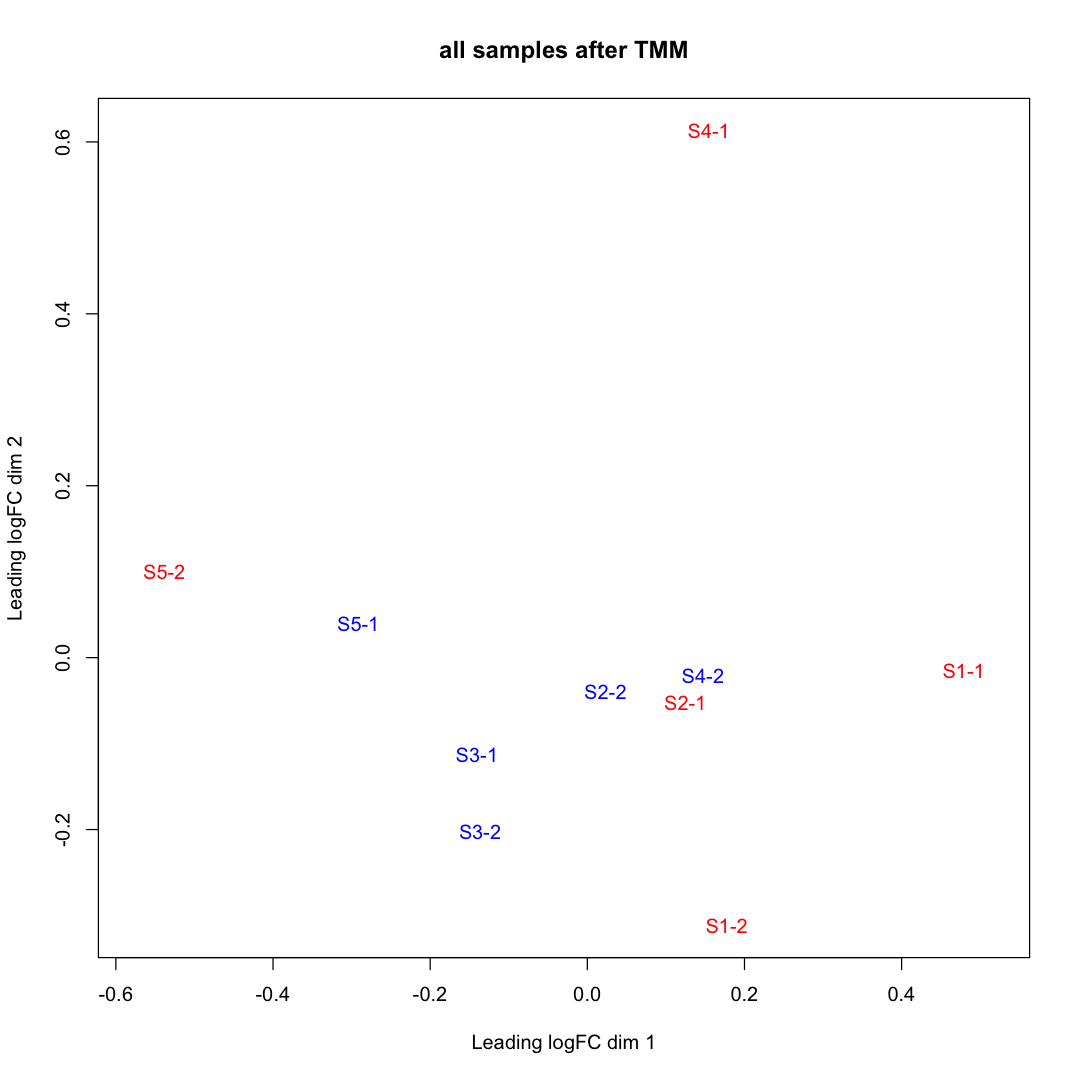

In [7]:
# check the clustering
plotMDS(y, col = colors_group, main = "all samples after TMM")

### The groups do not have large separation

Red and blue samples should not be different, and we do not see any tendencies towards separate clusters.

## EdgeR statistical testing starts here

### Compute the shared variance trend

One of the more powerful features of edgeR is computing variances across larger numbers of genes (proteins) to get more robust variance estimates for small replicate experiments. Here, we have 10 samples to use to improve the variance estimates and reduce false positive differential expression (DE) candidates. We have an edgeR `estimateDisp` function that does all of this and a visualization function to check the result.

We need to estimate the dispersion parameters before we can do the actual statistical testing. This only needs to be done once. Each exact test will take specified conditions and compare them using the normalization factors and dispersion estimates saved in the DGEList object `y`.

Design matrix not provided. Switch to the classic mode.


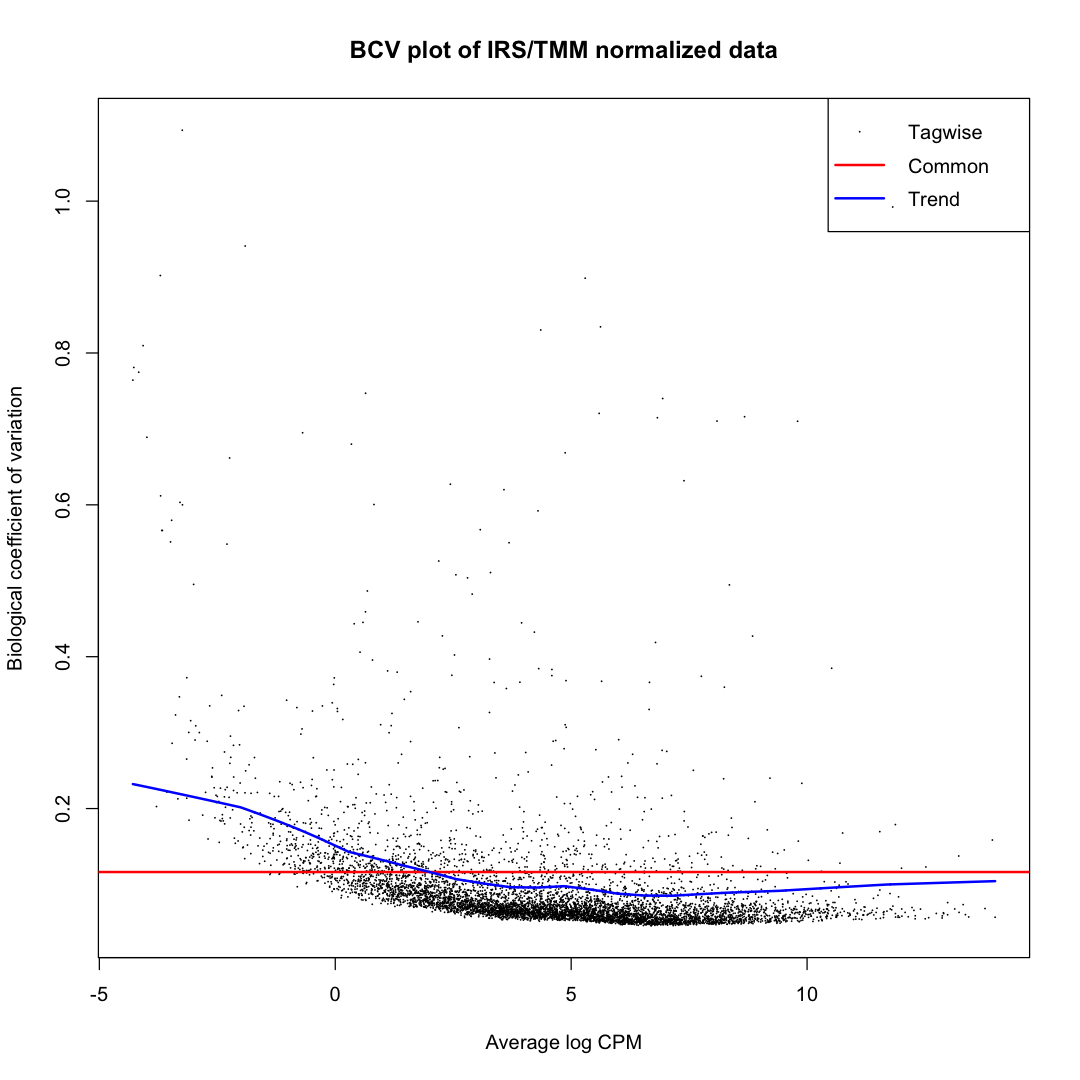

In [8]:
# compute dispersions and plot BCV
y <- estimateDisp(y)
plotBCV(y, main = "BCV plot of IRS/TMM normalized data")

## <a name="DE"></a>Compare random Set1 (n=5) versus Set2 (n=5)

Compare two sets of random mouse brain background samples. We should expect few, if any, DE candidates.

We will specify the pair of interest for the exact test in edgeR and use the experiment-wide dispersion. The `topTags` table show us the most significant candidates (top 10). We can also summarize how many up and down regulated candidates we have at an FDR of 0.10.  We save the test results in `tt`. We use a handy MA (mean-average) plotting function from `limma` to visualize the DE candidates, and check the p-value distribution.


                      genes   logFC logCPM    PValue    FDR
2901   sp|O88662|EMP2_MOUSE  0.2954  4.937 8.071e-05 0.5277
2246   sp|Q9D8B7|JAM3_MOUSE -0.2982  5.717 1.744e-04 0.5703
5402   sp|Q6NS46|RRP5_MOUSE -0.5148  1.767 2.703e-04 0.5893
6390  sp|Q8VC51|TCAB1_MOUSE  0.4165 -1.075 3.728e-04 0.6095
5049 tr|Q80X81|Q80X81_MOUSE  0.2723  2.311 5.792e-04 0.7443
3720  sp|Q8CFE6|S38A2_MOUSE -0.2551  4.007 9.772e-04 0.7443
2390   sp|Q922J6|TSN2_MOUSE -0.4909  5.540 1.145e-03 0.7443
1162  sp|O09131|GSTO1_MOUSE -0.1649  7.187 1.191e-03 0.7443
3730   sp|P01872|IGHM_MOUSE -0.5793  3.999 1.255e-03 0.7443
5940  sp|Q9D387|LAMP5_MOUSE -1.4298  0.681 1.692e-03 0.7443

       SET2-SET1
Down           0
NotSig      6539
Up             0


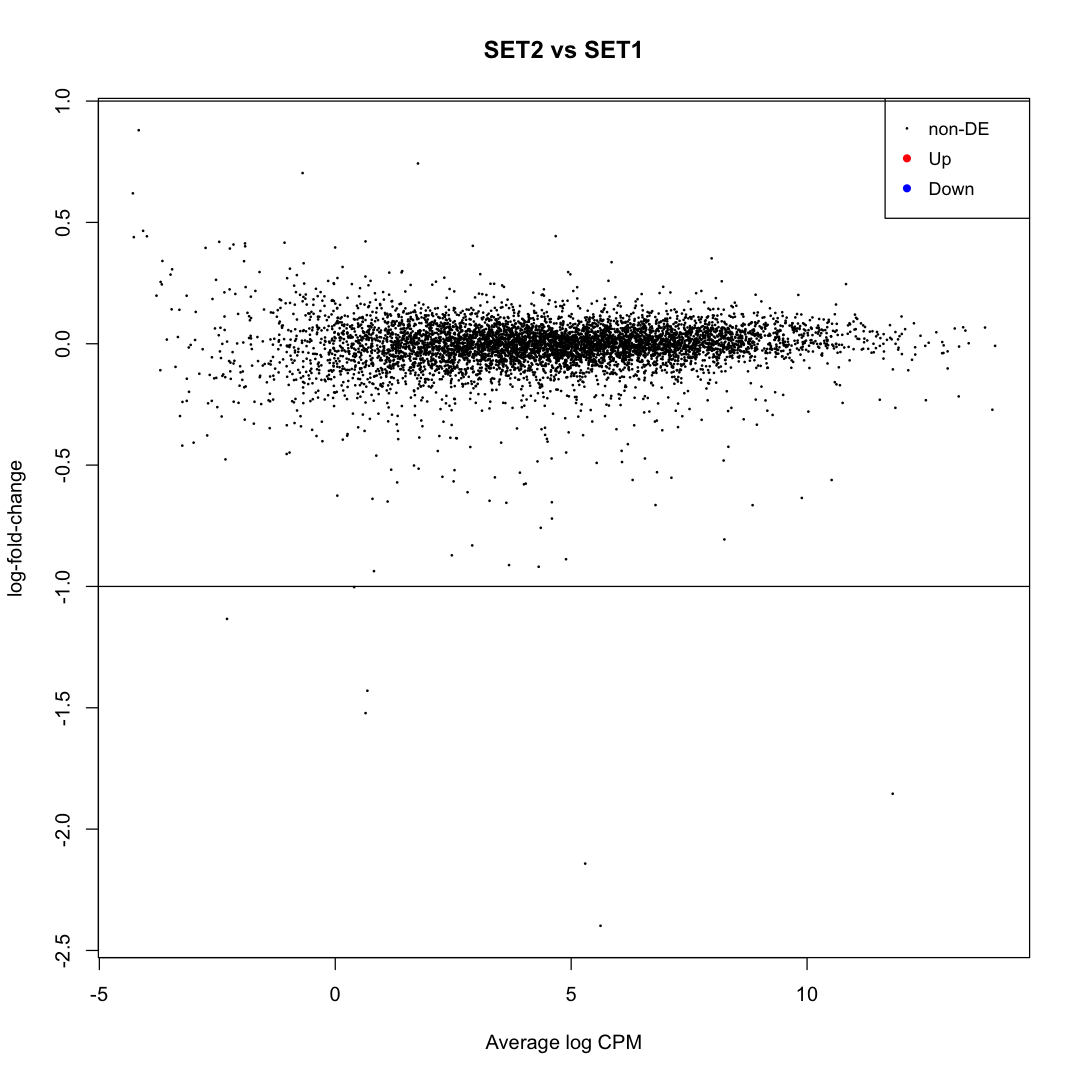

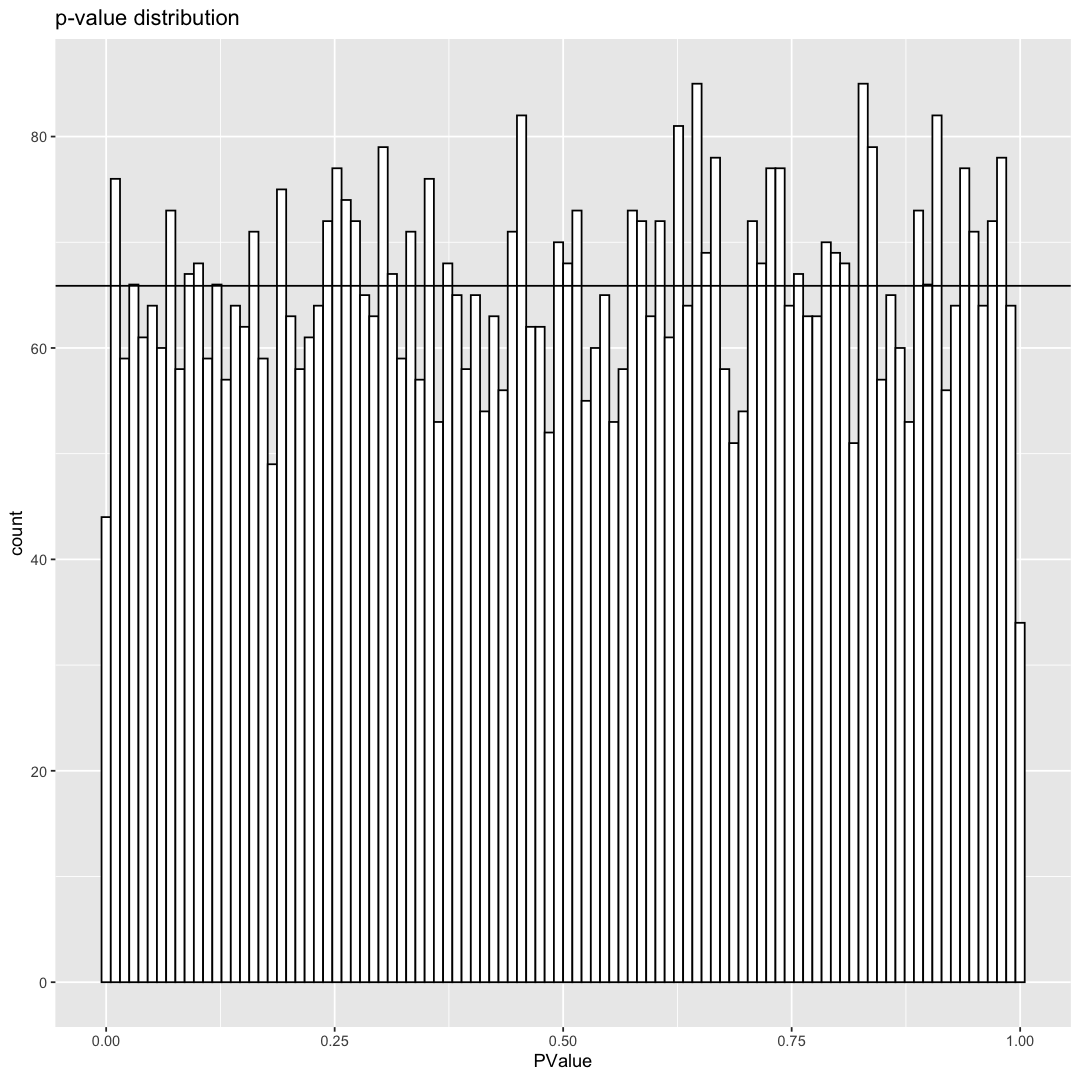

In [9]:
tt = pairwise_test(y, c("SET1", "SET2"), 0.05)

### We have one DE candidates at an FDR cutoff of 5%

We have a beautiful null result. The data is very well normalized and very few proteins have abundances that are not centered along the horizontal 0-FC line in the MA plot. The p-value distribution is flat-ish from 0 to 1 as expected for no DE changes.  

## Compute averages, flag candidates, and save the pair-wise test results

We will add the statistical testing results (logFC, p-values, and FDR), condition intensity averages, and candidate status to the `results` data frame (which has the TMM-normalized data) and accumulate all comparisons into `all_results`.

We will make MA plots, scatter plots, and a volcano plot using ggplot2. We will also look at the distribution of log2 expression ratios separated by differential expression (DE) category. The Benjamini-Hochberg corrected edgeR p-values are used to categorize the DE candidates: no > 0.10 > low > 0.05 > med > 0.01 > high.

In [10]:
# get the results summary
results <- collect_results(tmt_tmm, tt$table, SET1, "SET1", SET2, "SET2")

# make column names unique by adding comparison (for the accumulated frame)
results_temp  <- results
colnames(results_temp) <- str_c(colnames(results), "_SET1-2")

# accumulate testing results
all_results <- cbind(accessions, results_temp)

### Count candidates and look at fold-change distributions


  candidate    n
1        no 6539



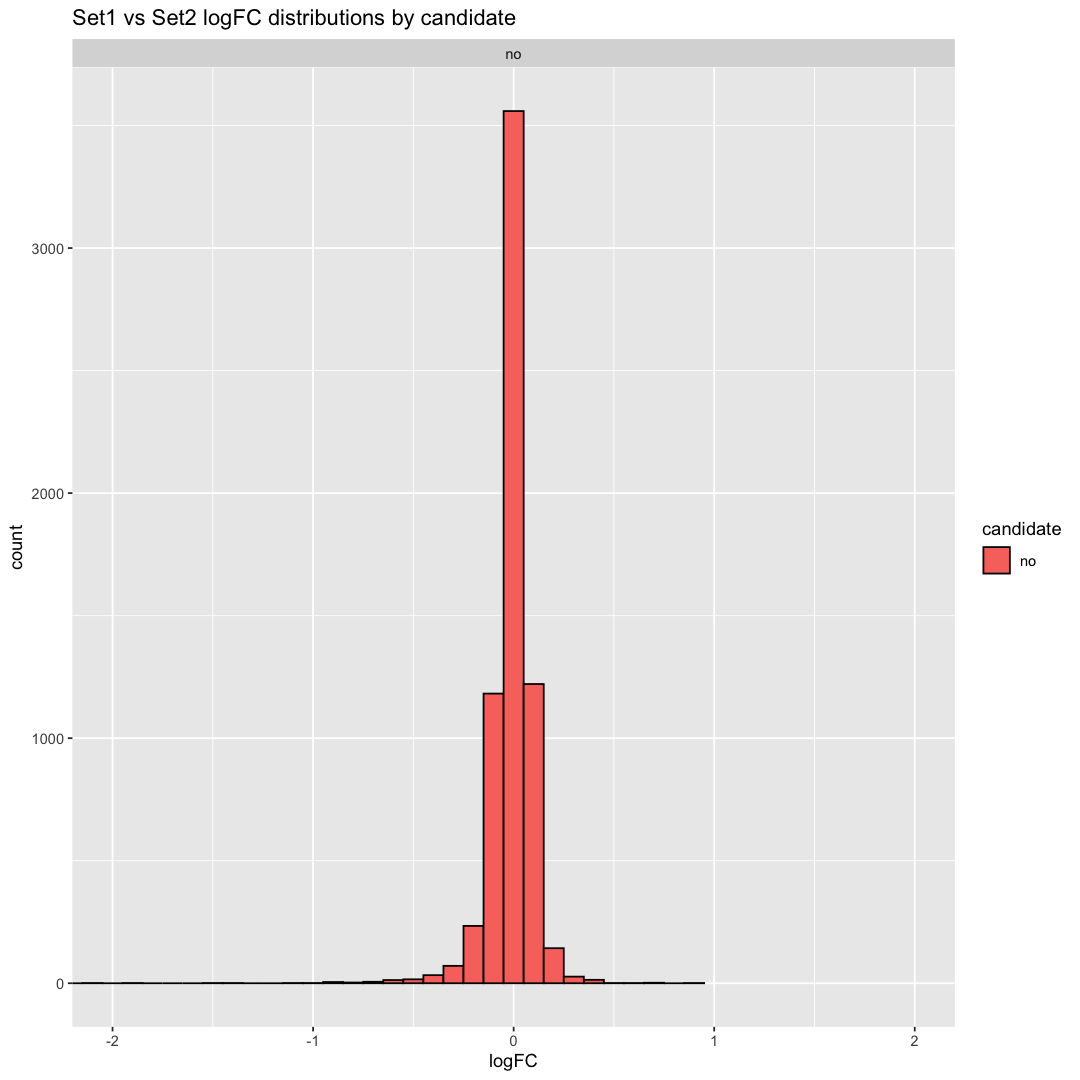

In [11]:
# count candidates and check log2 fold change distributions
log2_fold_changes(results, 2, 2, "Set1 vs Set2 logFC distributions by candidate")

## Main summary plots

We have many comparisons to visualize, so we will use functions to generate a series of plots. We will make: an MA plot with candidates highlighted by color, faceted MA plots separated by candidate status, a scatter plot with candidates highlighted by color, faceted scatter plots separated by candidate status, and a volcano plot with candidates highlighted by color. The solid black lines in the MA and scatter plots are the 1-to-1 lines; the dotted lines are 2-fold change lines.

### MA plots

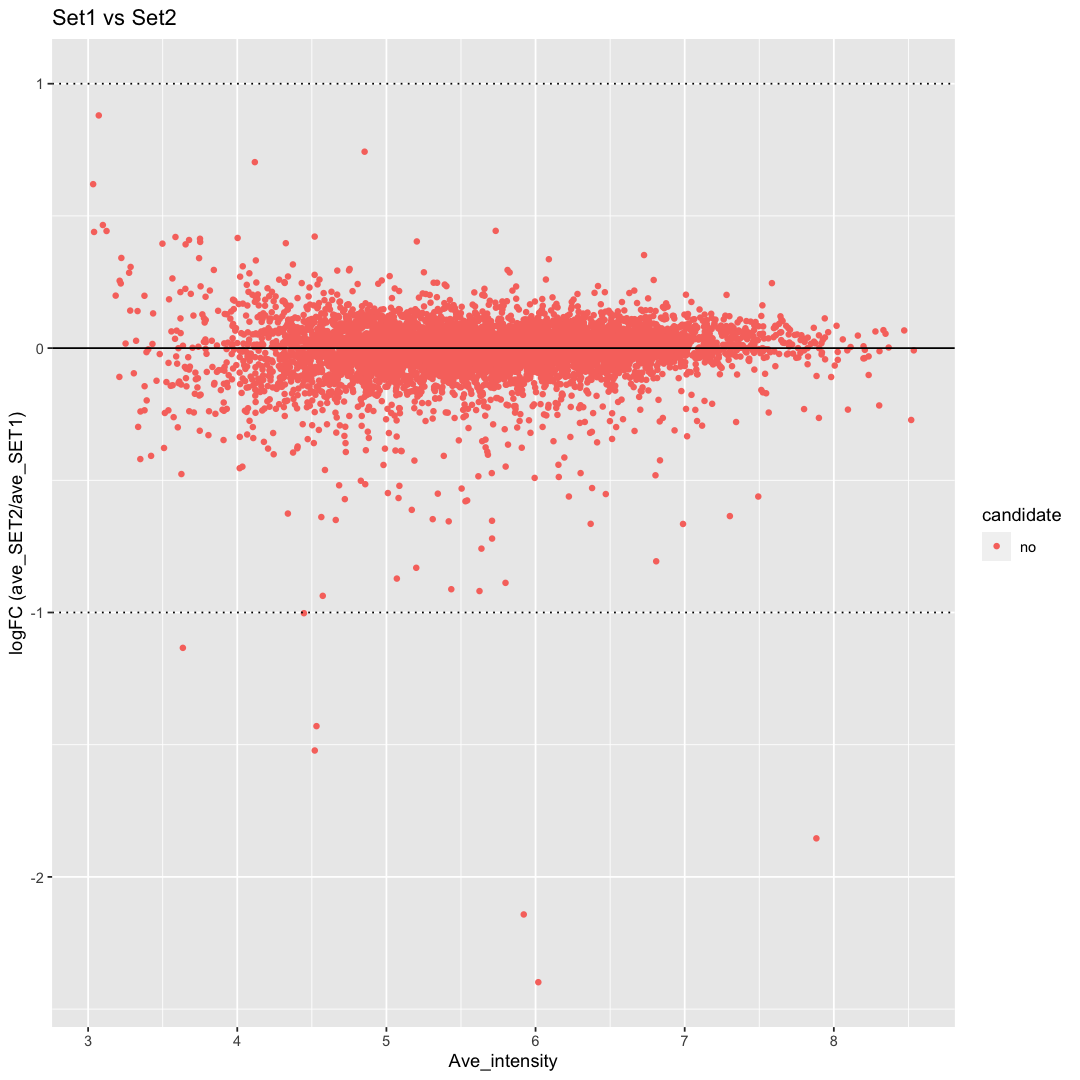

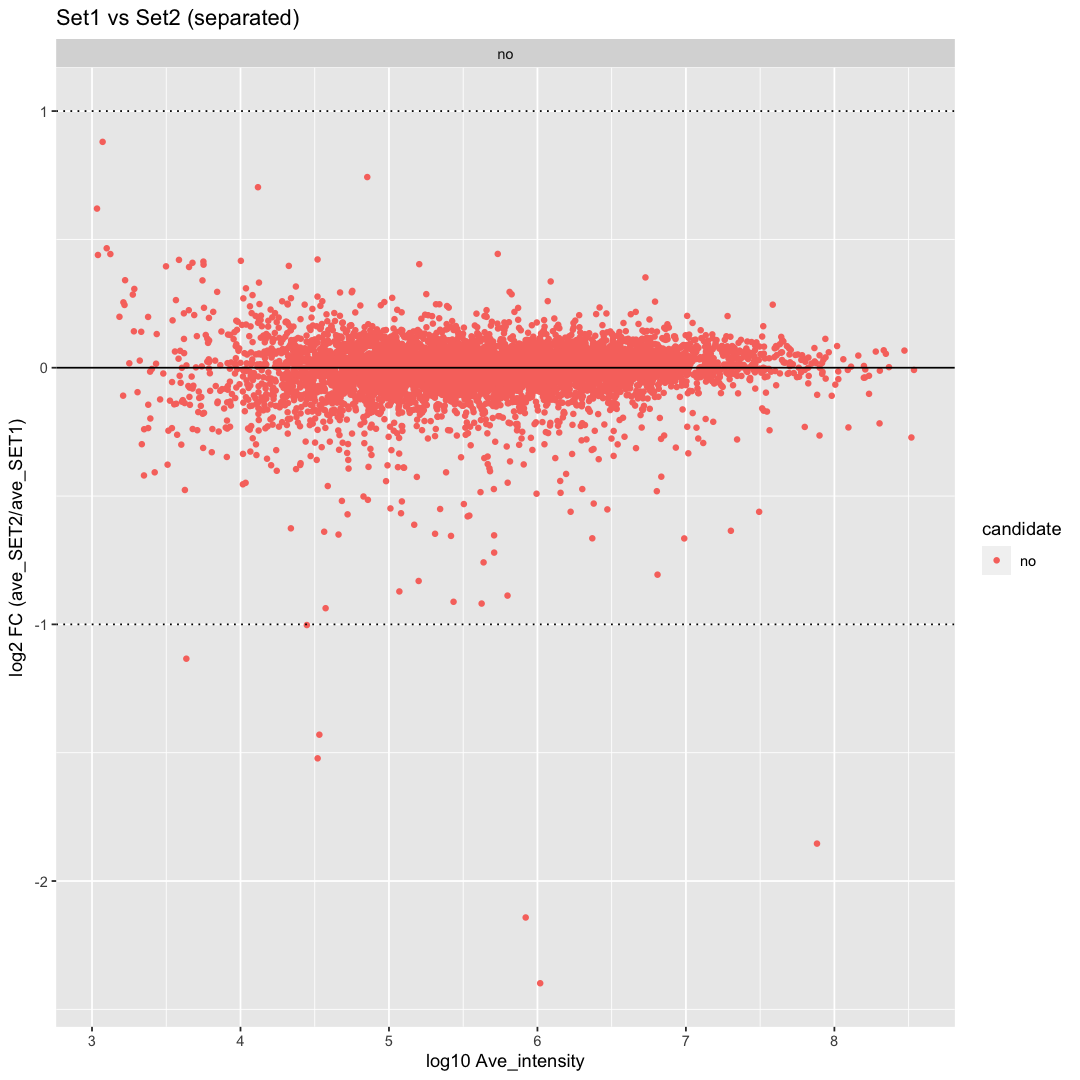

In [12]:
# make MA plots
MA_plots(results, "ave_SET1", "ave_SET2", "Set1 vs Set2")

### The non-candidates have a typical pattern

We have a few proteins with some positive and negative fold changes that might be the UPS2 proteins or possible contaminant proteins. We have over 6,200 proteins in the plot, after all. We see the typical data dispersion trend where the high abundance proteins are pinched a bit in terms of their freedom for abundance changes. The lower abundance proteins have larger dispersion for a few reasons: the measurements get less reliable, fewer PSMs are summed for lower abundance proteins, and there is more freedom for abundance changes. One always needs to keep in mind that relative abundances within a proteome are a constrained system. Bench steps fix the total protein amount (or peptide amounts if those are assayed). High abundance proteins contribute more to the fixed totals, so they are constrained. Low abundance proteins do not affect the grand total much and have more freedom to change abundance. 

### Scatter plots

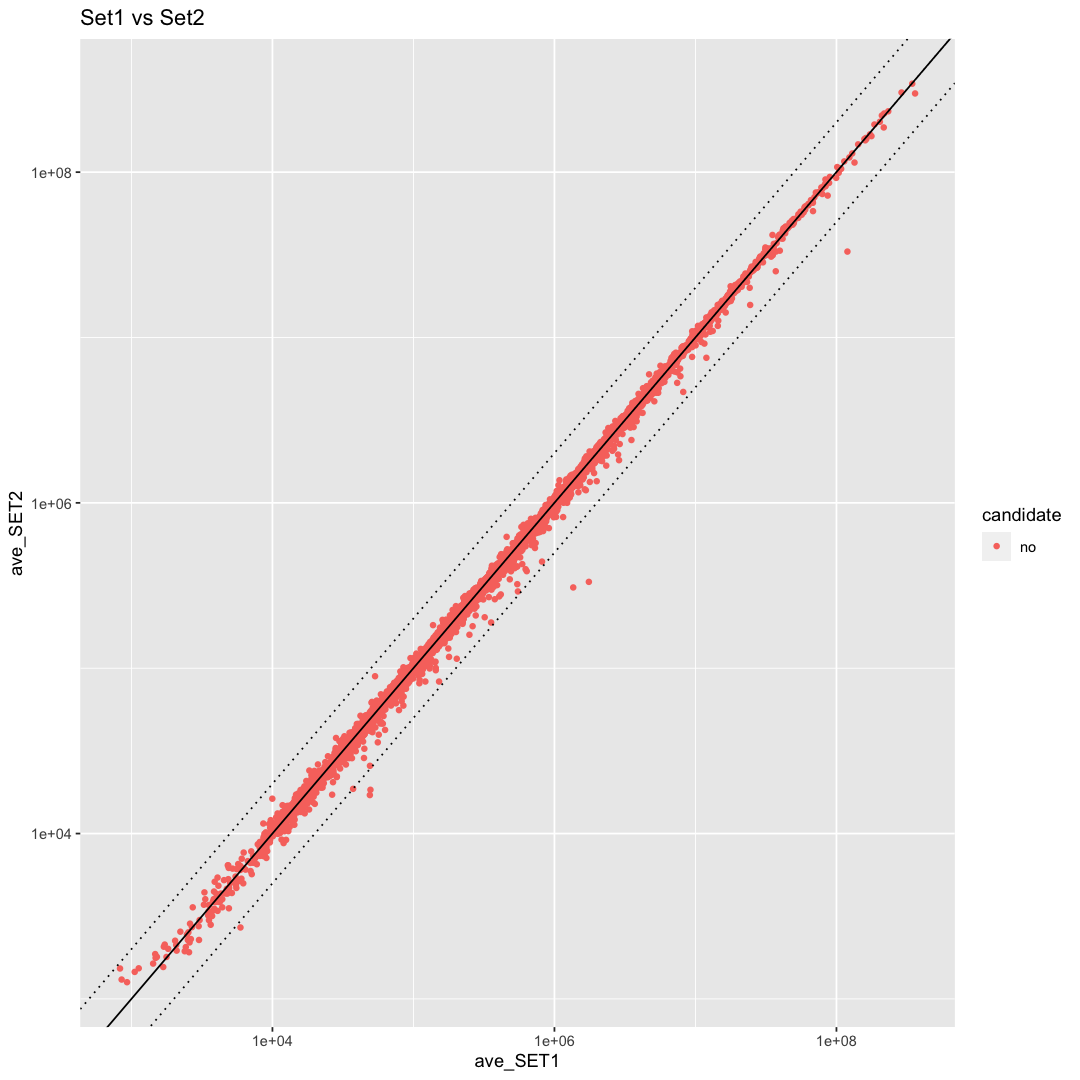

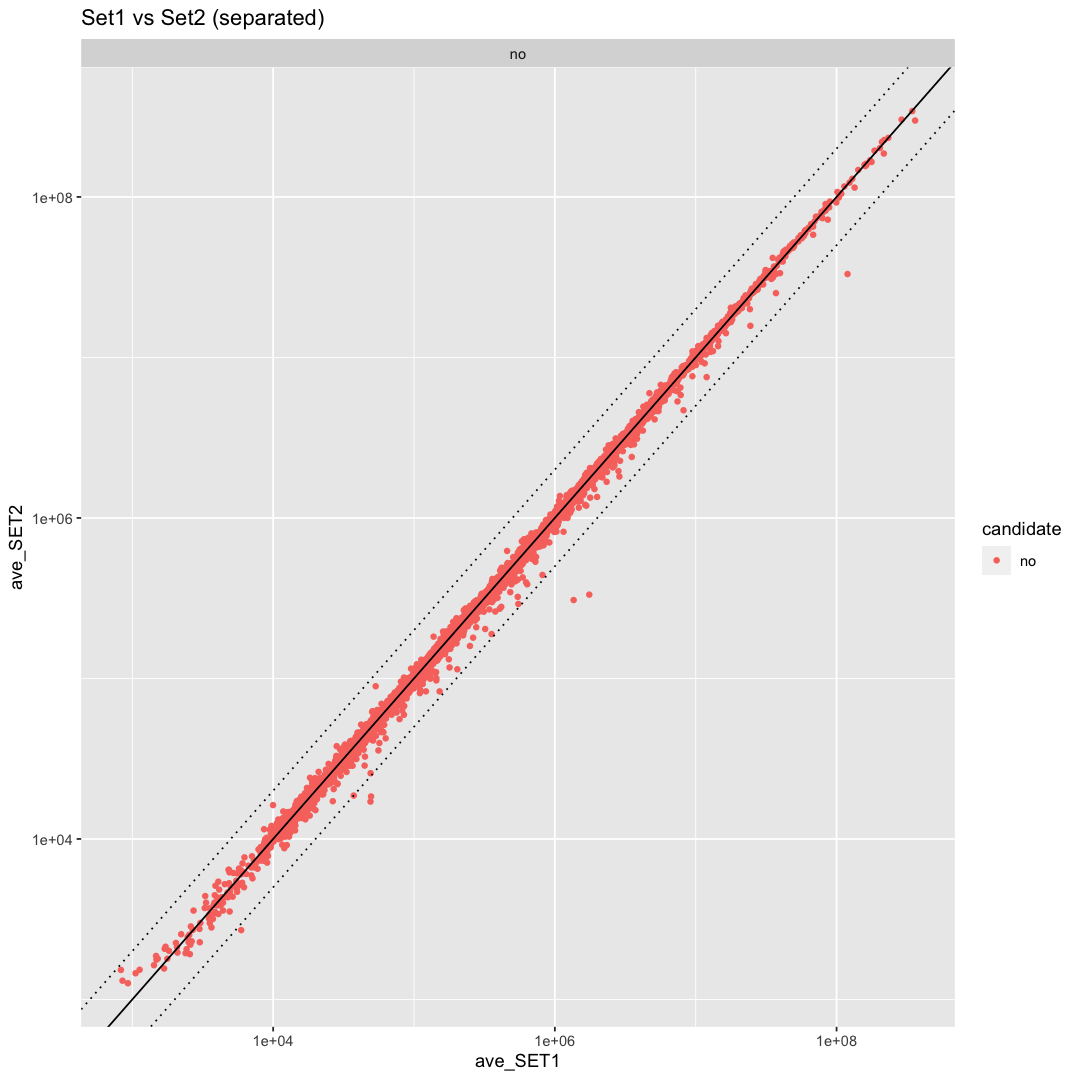

In [13]:
# make scatter plots
scatter_plots(results, "ave_SET1", "ave_SET2", "Set1 vs Set2")

### Volcano plot

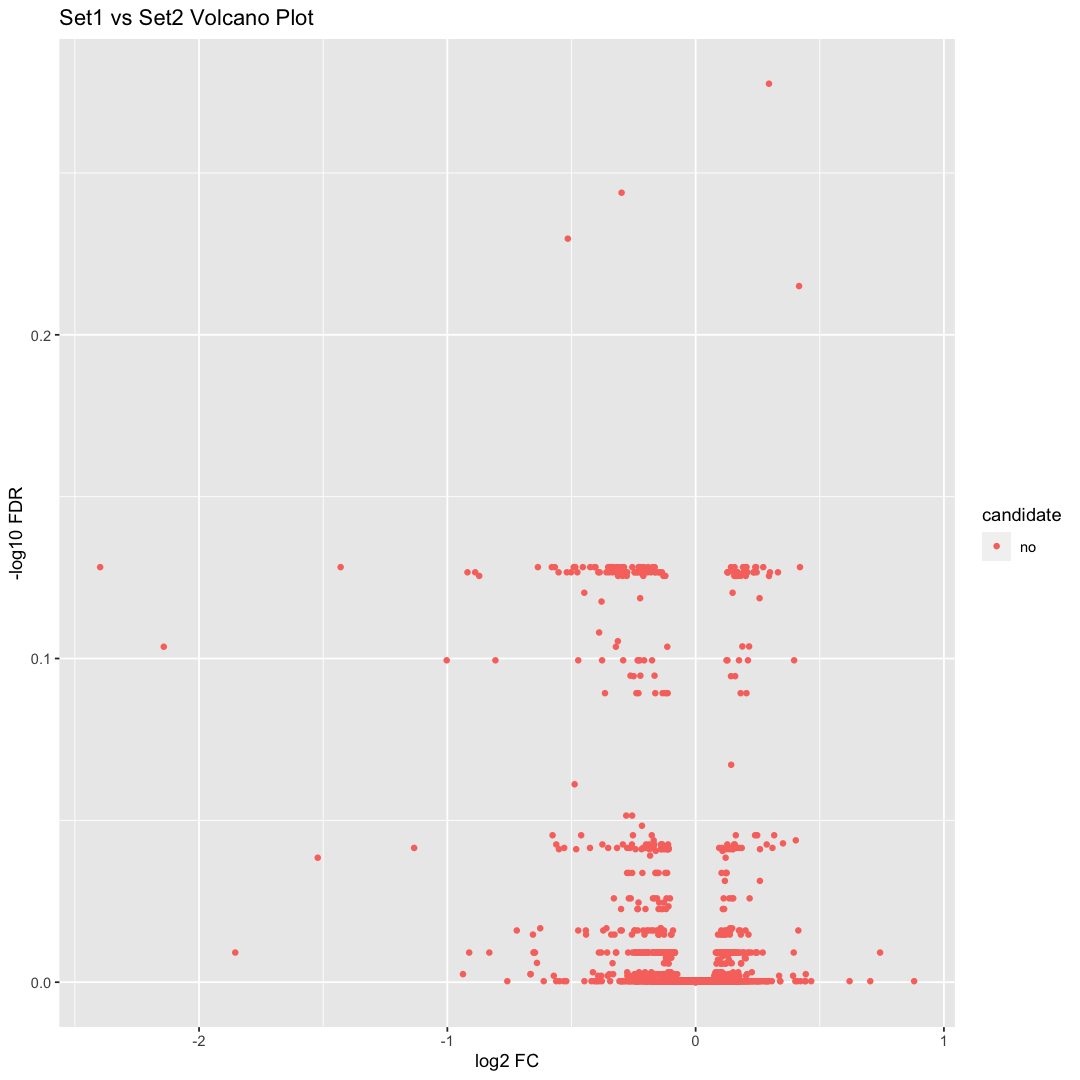

In [14]:
# make a volcano plot
volcano_plot(results, "ave_SET1", "ave_SET2", "Set1 vs Set2")

### Check some individual non-candidate proteins

We do not have any DE candidates; however, we can still look at a few individual protein intensity plots. The `plot_top_tags` function sorts by FDR (Benjamini-Hochberg adjusted p-values) for the top N up and down DE candidates.

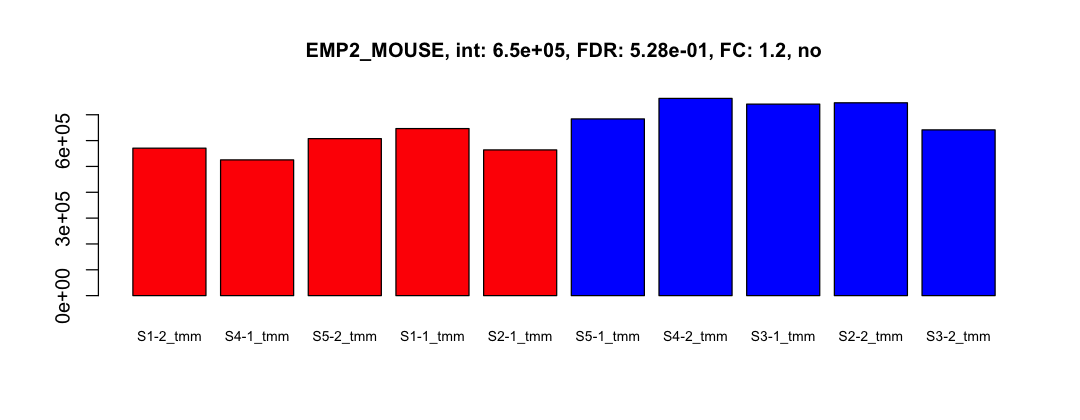

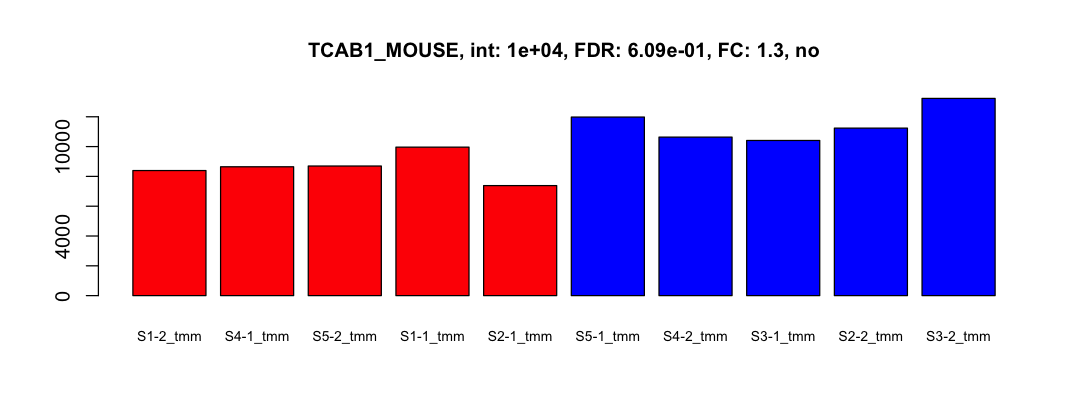

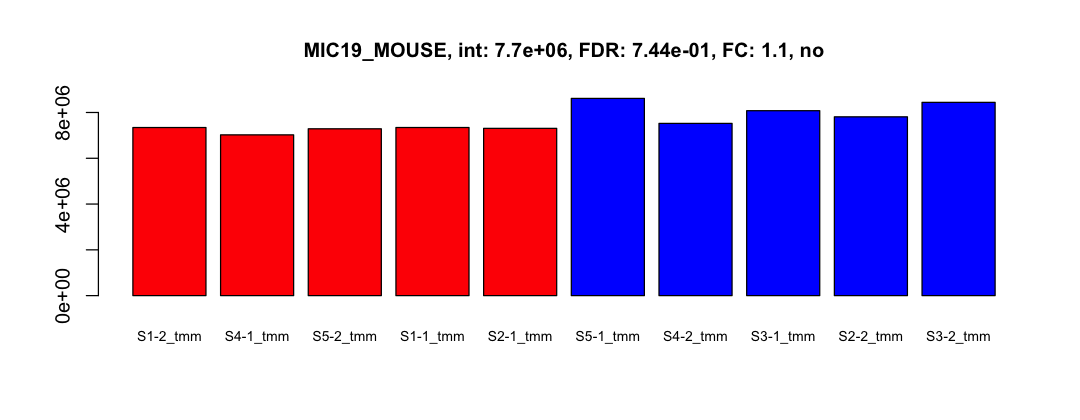

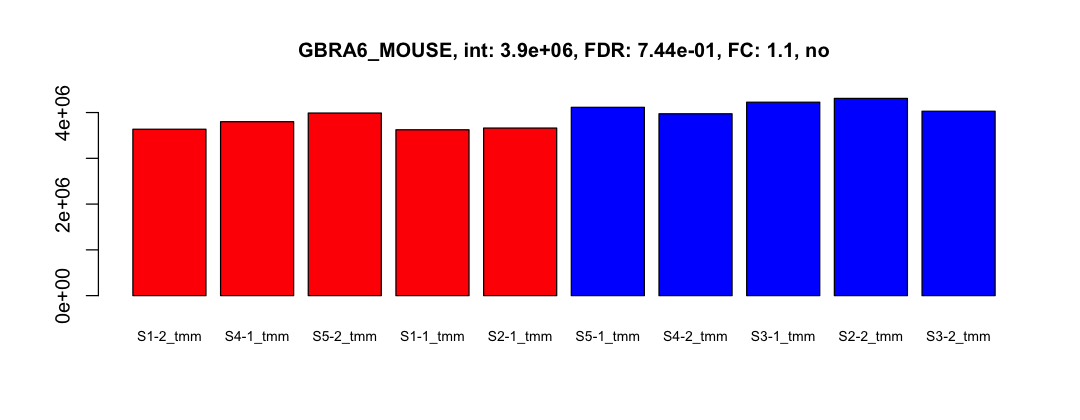

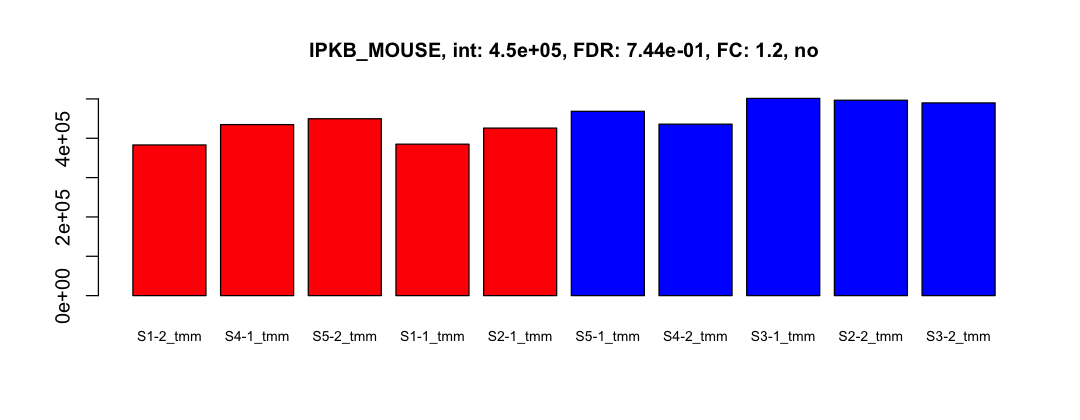

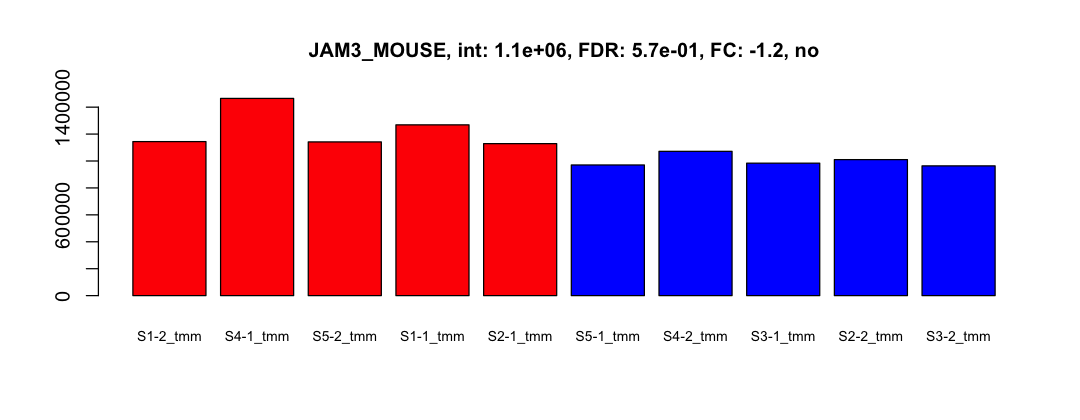

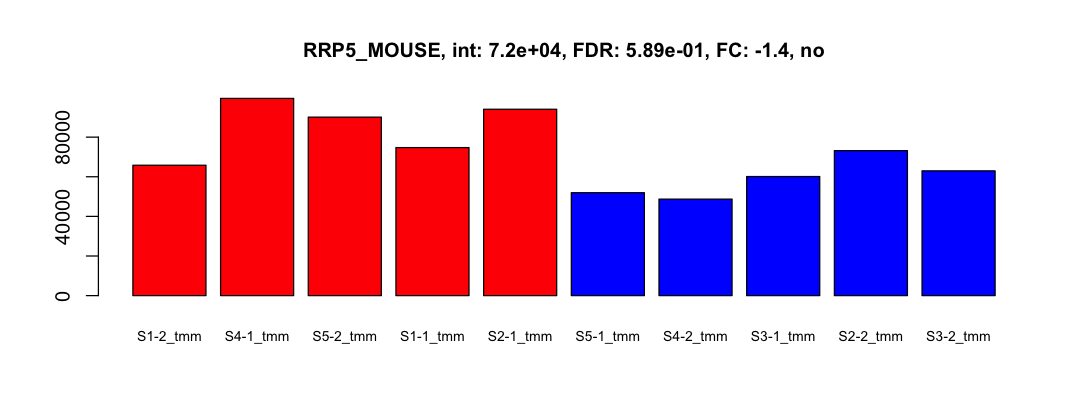

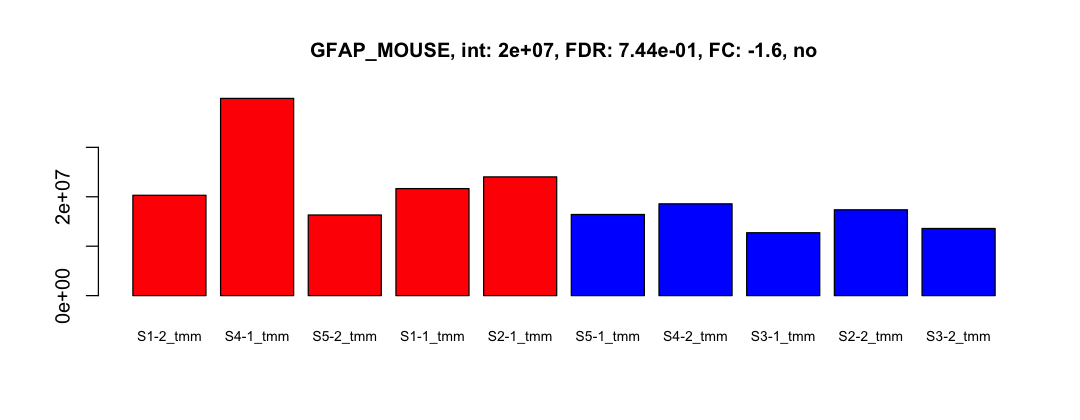

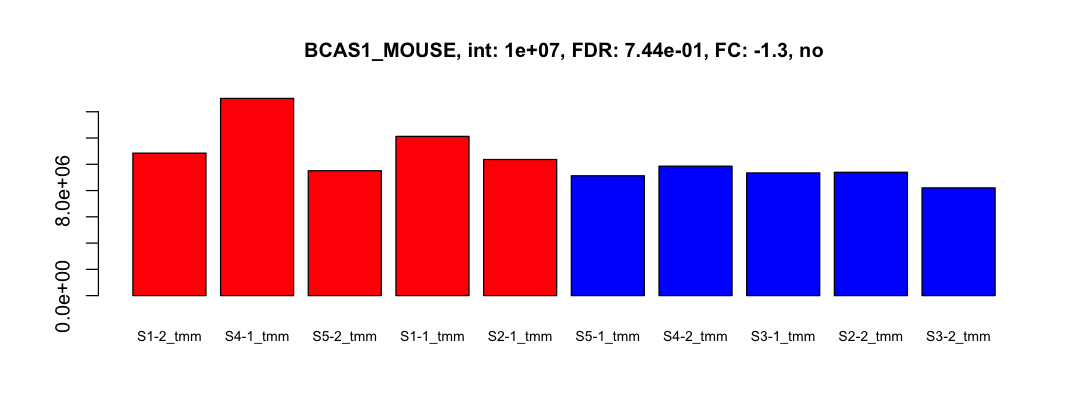

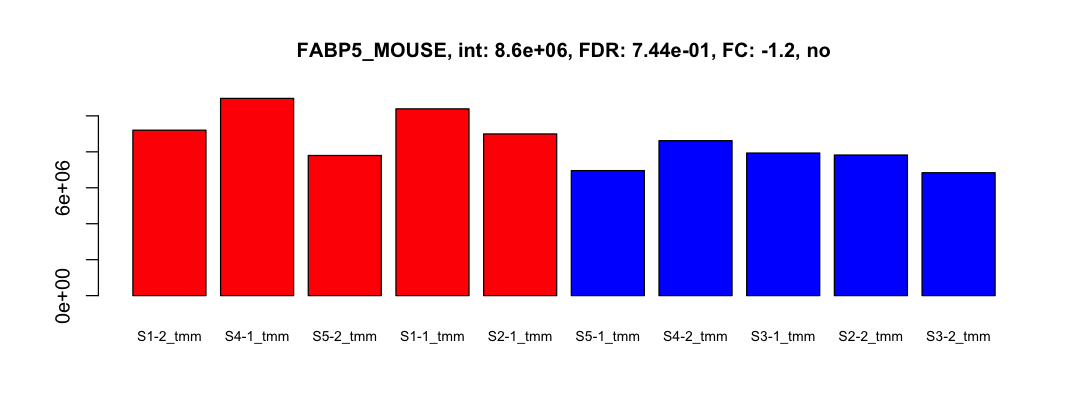

In [15]:
# look at the top candidates
set_plot_dimensions(9, 3.5)

n_left <- 5
n_right <- 5
top_tags <- 5
color <- c("red", "blue") 

plot_top_tags(results, n_left, n_right, top_tags, color)
set_plot_dimensions(9, 9)

## <a name="summary"></a> Summary

The normalizations and variance estimates were done experiment-wide using all 10 samples. The background of mouse brain proteins (10 independent biological replicates) is very constant.   

---
## Save the `all_results` frame to TSV file

We collected the normalized data and statistical testing results from all three comparisons. We can save that table and make a nice spreadsheet summary.

In [16]:
write.table(all_results, "BGS_results_edgeR-exact-random.txt", sep = "\t",
           row.names = FALSE, na =  " ")

## Log the session information

In [17]:
sessionInfo()

R version 3.5.3 (2019-03-11)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.0.7     edgeR_3.24.3    limma_3.38.3    scales_1.1.1   
 [5] forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2     purrr_0.3.4    
 [9] readr_1.3.1     tidyr_1.1.1     tibble_3.0.3    ggplot2_3.3.2  
[13] tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       locfit_1.5-9.4   lubridate_1.7.9  lattice_0.20-41 
 [5] assertthat_0.2.1 digest_0.6.25    IRdisplay_0.7.0  R6_2.4.1        
 [9] cellranger_1.1.0 repr_1.1.0       backports_1.1.8  reprex_0.3.0    
[13] evaluate_0